In [1]:
# Notebook 3: Construction de la matrice de temps de trajet

import pandas as pd
import numpy as np
import networkx as nx
from geopy.distance import geodesic
import osmnx as ox
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=== CONSTRUCTION DE LA MATRICE DE TEMPS DE TRAJET - ML-TuniMapAi ===")
print()

=== CONSTRUCTION DE LA MATRICE DE TEMPS DE TRAJET - ML-TuniMapAi ===



In [2]:
# 1. CHARGEMENT DES DONNÉES PRÉPROCESSÉES
print("1. CHARGEMENT DES DONNÉES PRÉPROCESSÉES")
print("-" * 60)

# Chargement des données
delegations_df = pd.read_csv('../data/processed/tunisia_delegations_processed.csv')
ml_features = pd.read_csv('../data/processed/tunisia_ml_features.csv')

print(f"Données chargées:")
print(f"- Points géographiques: {len(delegations_df)}")
print(f"- Features ML: {len(ml_features.columns)} colonnes")
print()

1. CHARGEMENT DES DONNÉES PRÉPROCESSÉES
------------------------------------------------------------
Données chargées:
- Points géographiques: 4788
- Features ML: 25 colonnes



In [3]:
# 2. DÉFINITION DES PARAMÈTRES DE TRANSPORT
print("2. DÉFINITION DES PARAMÈTRES DE TRANSPORT")
print("-" * 60)

# Paramètres détaillés pour chaque mode de transport
TRANSPORT_PARAMS = {
    'walking': {
        'base_speed_kmh': 4,
        'detour_factor': 1.0,
        'waiting_time_min': 0,
        'comfort_factor': 1.0,
        'weather_sensitivity': 0.3,
        'max_reasonable_distance': 5  # km
    },
    'bike': {
        'base_speed_kmh': 15,
        'detour_factor': 1.1,
        'waiting_time_min': 2,
        'comfort_factor': 0.8,
        'weather_sensitivity': 0.4,
        'max_reasonable_distance': 20
    },
    'bus': {
        'base_speed_kmh': 25,
        'detour_factor': 1.6,
        'waiting_time_min': 12,
        'comfort_factor': 0.7,
        'weather_sensitivity': 0.1,
        'max_reasonable_distance': 100
    },
    'metro': {
        'base_speed_kmh': 35,
        'detour_factor': 1.4,
        'waiting_time_min': 8,
        'comfort_factor': 0.9,
        'weather_sensitivity': 0.0,
        'max_reasonable_distance': 50
    },
    'train': {
        'base_speed_kmh': 60,
        'detour_factor': 1.5,
        'waiting_time_min': 15,
        'comfort_factor': 0.8,
        'weather_sensitivity': 0.0,
        'max_reasonable_distance': 300
    },
    'taxi': {
        'base_speed_kmh': 28,
        'detour_factor': 1.2,
        'waiting_time_min': 8,
        'comfort_factor': 0.9,
        'weather_sensitivity': 0.1,
        'max_reasonable_distance': 100
    },
    'car_city': {
        'base_speed_kmh': 30,
        'detour_factor': 1.2,
        'waiting_time_min': 3,
        'comfort_factor': 1.0,
        'weather_sensitivity': 0.05,
        'max_reasonable_distance': 150
    },
    'car_highway': {
        'base_speed_kmh': 90,
        'detour_factor': 1.1,
        'waiting_time_min': 5,
        'comfort_factor': 1.0,
        'weather_sensitivity': 0.1,
        'max_reasonable_distance': 500
    }
}

# Paramètres pour différents types de voitures (par chevaux)
CAR_PERFORMANCE = {
    'economy_60hp': {'speed_factor': 0.85, 'fuel_efficiency': 1.2},
    'standard_90hp': {'speed_factor': 1.0, 'fuel_efficiency': 1.0},
    'mid_120hp': {'speed_factor': 1.1, 'fuel_efficiency': 0.9},
    'premium_150hp': {'speed_factor': 1.2, 'fuel_efficiency': 0.8},
    'sport_200hp': {'speed_factor': 1.4, 'fuel_efficiency': 0.6},
    'luxury_300hp': {'speed_factor': 1.5, 'fuel_efficiency': 0.5}
}

print("Paramètres de transport configurés:")
for mode, params in TRANSPORT_PARAMS.items():
    print(f"- {mode}: {params['base_speed_kmh']}km/h, détour: {params['detour_factor']:.1f}x")

print(f"\nTypes de voitures: {len(CAR_PERFORMANCE)} catégories")
print()

2. DÉFINITION DES PARAMÈTRES DE TRANSPORT
------------------------------------------------------------
Paramètres de transport configurés:
- walking: 4km/h, détour: 1.0x
- bike: 15km/h, détour: 1.1x
- bus: 25km/h, détour: 1.6x
- metro: 35km/h, détour: 1.4x
- train: 60km/h, détour: 1.5x
- taxi: 28km/h, détour: 1.2x
- car_city: 30km/h, détour: 1.2x
- car_highway: 90km/h, détour: 1.1x

Types de voitures: 6 catégories



In [4]:
# 3. CALCUL DES DISTANCES GÉODÉSIQUES
print("3. CALCUL DES DISTANCES GÉODÉSIQUES")
print("-" * 60)

def calculate_distance_matrix(df):
    """Calcule la matrice des distances entre tous les points"""
    n_points = len(df)
    distance_matrix = np.zeros((n_points, n_points))
    
    print(f"Calcul de {n_points}x{n_points} distances...")
    
    # Calcul optimisé avec indexation
    coords = df[['Latitude', 'Longitude']].values
    
    for i in tqdm(range(n_points), desc="Calcul distances"):
        for j in range(i+1, n_points):
            dist = geodesic(coords[i], coords[j]).kilometers
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Matrice symétrique
    
    return distance_matrix

# Calcul de la matrice de distances
distance_matrix = calculate_distance_matrix(delegations_df)

print(f"Matrice de distances calculée: {distance_matrix.shape}")
print(f"Distance moyenne: {distance_matrix[distance_matrix > 0].mean():.2f} km")
print(f"Distance max: {distance_matrix.max():.2f} km")
print()

3. CALCUL DES DISTANCES GÉODÉSIQUES
------------------------------------------------------------
Calcul de 4788x4788 distances...


Calcul distances: 100%|██████████| 4788/4788 [38:16<00:00,  2.08it/s] 


Matrice de distances calculée: (4788, 4788)
Distance moyenne: 178.38 km
Distance max: 779.80 km



In [5]:
# 4. SIMULATION DU RÉSEAU ROUTIER
print("4. SIMULATION DU RÉSEAU ROUTIER")
print("-" * 60)

def simulate_road_network(df, distance_matrix):
    """Simule un réseau routier réaliste"""
    n_points = len(df)
    
    # Types de routes avec leurs caractéristiques
    road_types = {
        'highway': {'speed_factor': 1.5, 'availability': 0.1},
        'main_road': {'speed_factor': 1.2, 'availability': 0.3},
        'secondary': {'speed_factor': 1.0, 'availability': 0.4},
        'local': {'speed_factor': 0.8, 'availability': 0.2}
    }
    
    # Création du graphe du réseau
    road_network = np.full((n_points, n_points), 'local')  # Par défaut: routes locales
    
    # Assignation des types de routes selon la distance
    for i in range(n_points):
        for j in range(i+1, n_points):
            distance = distance_matrix[i, j]
            
            # Probabilités basées sur la distance
            if distance > 100:  # Longue distance
                road_type = np.random.choice(['highway', 'main_road'], p=[0.7, 0.3])
            elif distance > 50:  # Distance moyenne
                road_type = np.random.choice(['main_road', 'secondary'], p=[0.6, 0.4])
            elif distance > 20:  # Courte distance
                road_type = np.random.choice(['secondary', 'local'], p=[0.7, 0.3])
            else:  # Très courte distance
                road_type = 'local'
            
            road_network[i, j] = road_type
            road_network[j, i] = road_type
    
    return road_network, road_types

road_network, road_types = simulate_road_network(delegations_df, distance_matrix)

print("Réseau routier simulé:")
unique, counts = np.unique(road_network[np.triu_indices(len(delegations_df), k=1)], return_counts=True)
for road_type, count in zip(unique, counts):
    percentage = (count / counts.sum()) * 100
    print(f"- {road_type}: {count} connexions ({percentage:.1f}%)")

print()

4. SIMULATION DU RÉSEAU ROUTIER
------------------------------------------------------------
Réseau routier simulé:
- highw: 5893274 connexions (51.4%)
- local: 619172 connexions (5.4%)
- main_: 3642712 connexions (31.8%)
- secon: 1304920 connexions (11.4%)



In [6]:
# 5. CALCUL DES TEMPS DE TRAJET
print("5. CALCUL DES TEMPS DE TRAJET")
print("-" * 60)

def calculate_travel_times(distance_matrix, road_network, road_types, transport_params, df):
    """Calcule les temps de trajet pour tous les modes de transport"""
    n_points = len(df)
    travel_times = {}
    
    # Pour chaque mode de transport
    for transport_mode, params in transport_params.items():
        print(f"  Calcul pour {transport_mode}...")
        time_matrix = np.zeros((n_points, n_points))
        
        for i in range(n_points):
            for j in range(n_points):
                if i == j:
                    time_matrix[i, j] = 0
                    continue
                
                distance = distance_matrix[i, j]
                
                # Vérification de la distance maximale raisonnable
                if distance > params['max_reasonable_distance']:
                    time_matrix[i, j] = np.inf  # Pas de trajet direct
                    continue
                
                # Vérification de la disponibilité du transport
                origin_available = df.iloc[i].get(f'has_{transport_mode}_station', True)
                dest_available = df.iloc[j].get(f'has_{transport_mode}_station', True)
                
                if transport_mode in ['bus', 'metro', 'train'] and not (origin_available and dest_available):
                    time_matrix[i, j] = np.inf  # Transport non disponible
                    continue
                
                # Calcul du temps de base
                road_type = road_network[i, j] if transport_mode.startswith('car') else 'main_road'
                road_speed_factor = road_types.get(road_type, {}).get('speed_factor', 1.0)
                
                # Vitesse effective
                effective_speed = params['base_speed_kmh'] * road_speed_factor
                
                # Temps de trajet pur
                travel_time_hours = (distance * params['detour_factor']) / effective_speed
                
                # Ajout du temps d'attente
                waiting_time_hours = params['waiting_time_min'] / 60.0
                
                # Facteurs environnementaux (simulation)
                weather_factor = 1 + np.random.normal(0, params['weather_sensitivity'])
                weather_factor = max(0.7, min(1.5, weather_factor))
                
                # Temps total
                total_time = (travel_time_hours + waiting_time_hours) * weather_factor
                time_matrix[i, j] = total_time
        
        travel_times[transport_mode] = time_matrix
    
    return travel_times

# Calcul des temps de trajet
travel_times = calculate_travel_times(distance_matrix, road_network, road_types, TRANSPORT_PARAMS, delegations_df)

print(f"Temps de trajet calculés pour {len(travel_times)} modes de transport")

# Statistiques des temps de trajet
for mode, times in travel_times.items():
    finite_times = times[np.isfinite(times) & (times > 0)]
    if len(finite_times) > 0:
        print(f"- {mode}: {finite_times.mean():.1f}h moyenne, max: {finite_times.max():.1f}h")

print()

5. CALCUL DES TEMPS DE TRAJET
------------------------------------------------------------
  Calcul pour walking...
  Calcul pour bike...
  Calcul pour bus...
  Calcul pour metro...
  Calcul pour train...
  Calcul pour taxi...
  Calcul pour car_city...
  Calcul pour car_highway...
Temps de trajet calculés pour 8 modes de transport
- walking: 0.6h moyenne, max: 1.6h
- bike: 0.7h moyenne, max: 1.9h
- bus: 3.2h moyenne, max: 7.8h
- metro: 1.0h moyenne, max: 1.8h
- train: 3.4h moyenne, max: 6.5h
- taxi: 2.2h moyenne, max: 5.3h
- car_city: 3.5h moyenne, max: 7.4h
- car_highway: 2.2h moyenne, max: 8.3h



In [7]:
# 6. CALCUL SPÉCIALISÉ POUR VOITURES
print("6. CALCUL SPÉCIALISÉ POUR VOITURES SELON LA PUISSANCE")
print("-" * 60)

def calculate_car_performance_times(distance_matrix, road_network, road_types, base_times, car_performance):
    """Calcule les temps de trajet selon la puissance de la voiture"""
    car_times = {}
    
    base_city_times = base_times['car_city']
    base_highway_times = base_times['car_highway']
    
    for car_type, performance in car_performance.items():
        print(f"  Calcul pour {car_type}...")
        
        # Matrice hybride ville/autoroute selon la route
        car_time_matrix = np.zeros_like(base_city_times)
        
        for i in range(len(distance_matrix)):
            for j in range(len(distance_matrix)):
                if i == j:
                    continue
                
                distance = distance_matrix[i, j]
                road_type = road_network[i, j]
                
                # Choix du temps de base selon le type de route
                if road_type in ['highway', 'main_road'] and distance > 30:
                    base_time = base_highway_times[i, j]
                else:
                    base_time = base_city_times[i, j]
                
                # Application du facteur de performance
                if np.isfinite(base_time):
                    adjusted_time = base_time / performance['speed_factor']
                    car_time_matrix[i, j] = adjusted_time
                else:
                    car_time_matrix[i, j] = np.inf
        
        car_times[car_type] = car_time_matrix
    
    return car_times

# Calcul des temps par type de voiture
car_travel_times = calculate_car_performance_times(distance_matrix, road_network, road_types, travel_times, CAR_PERFORMANCE)

print(f"Temps calculés pour {len(car_travel_times)} types de voitures")

for car_type, times in car_travel_times.items():
    finite_times = times[np.isfinite(times) & (times > 0)]
    if len(finite_times) > 0:
        hp = car_type.split('_')[1]
        print(f"- {hp}: {finite_times.mean():.1f}h moyenne")

print()

6. CALCUL SPÉCIALISÉ POUR VOITURES SELON LA PUISSANCE
------------------------------------------------------------
  Calcul pour economy_60hp...
  Calcul pour standard_90hp...
  Calcul pour mid_120hp...
  Calcul pour premium_150hp...
  Calcul pour sport_200hp...
  Calcul pour luxury_300hp...
Temps calculés pour 6 types de voitures
- 60hp: 4.1h moyenne
- 90hp: 3.5h moyenne
- 120hp: 3.2h moyenne
- 150hp: 2.9h moyenne
- 200hp: 2.5h moyenne
- 300hp: 2.3h moyenne



In [8]:
# 7. MATRICE DE COÛTS ET CONFORT
print("7. CALCUL DES COÛTS ET SCORES DE CONFORT")
print("-" * 60)

def calculate_cost_comfort_matrices(distance_matrix, travel_times, car_times):
    """Calcule les matrices de coût et de confort"""
    
    # Coûts par km pour chaque mode (en dinars tunisiens approximatifs)
    cost_per_km = {
        'walking': 0,
        'bike': 0.02,  # Usure, entretien
        'bus': 0.15,
        'metro': 0.20,
        'train': 0.25,
        'taxi': 1.50,
        'car_city': 0.35,  # Carburant + usure
        'car_highway': 0.30
    }
    
    # Coûts pour les voitures selon le type
    car_cost_factors = {
        'economy_60hp': 0.8,
        'standard_90hp': 1.0,
        'mid_120hp': 1.2,
        'premium_150hp': 1.5,
        'sport_200hp': 2.0,
        'luxury_300hp': 2.5
    }
    
    cost_matrices = {}
    comfort_matrices = {}
    
    # Calcul pour les transports de base
    for mode, base_cost in cost_per_km.items():
        if mode in travel_times:
            cost_matrices[mode] = distance_matrix * base_cost
            
            # Score de confort (0-10)
            comfort_base = TRANSPORT_PARAMS[mode]['comfort_factor'] * 10
            comfort_variation = np.random.normal(comfort_base, 1, distance_matrix.shape)
            comfort_matrices[mode] = np.clip(comfort_variation, 1, 10)
    
    # Calcul pour les voitures spécialisées
    for car_type, cost_factor in car_cost_factors.items():
        base_cost = cost_per_km['car_city'] * cost_factor
        cost_matrices[car_type] = distance_matrix * base_cost
        
        # Confort selon le type de voiture
        comfort_base = 5 + (cost_factor - 1) * 2  # Plus cher = plus confortable
        comfort_variation = np.random.normal(comfort_base, 0.5, distance_matrix.shape)
        comfort_matrices[car_type] = np.clip(comfort_variation, 1, 10)
    
    return cost_matrices, comfort_matrices

cost_matrices, comfort_matrices = calculate_cost_comfort_matrices(distance_matrix, travel_times, car_travel_times)

print("Matrices de coût et confort calculées")
print("Coûts moyens par mode (pour 50km):")
for mode in list(cost_matrices.keys())[:8]:  # Premier 8 pour l'affichage
    avg_cost = np.mean(cost_matrices[mode][distance_matrix == 50]) if np.any(distance_matrix == 50) else 0
    if avg_cost > 0:
        print(f"- {mode}: {avg_cost:.2f} DT")

print()

7. CALCUL DES COÛTS ET SCORES DE CONFORT
------------------------------------------------------------
Matrices de coût et confort calculées
Coûts moyens par mode (pour 50km):



In [9]:
# 8. ALGORITHMES D'OPTIMISATION DE ROUTES
print("8. ALGORITHMES D'OPTIMISATION DE ROUTES")
print("-" * 60)

def find_optimal_route(origin_idx, destination_idx, travel_times, cost_matrices, comfort_matrices, preferences):
    """Trouve la route optimale selon les préférences utilisateur"""
    
    results = {}
    
    for mode in travel_times.keys():
        if mode not in cost_matrices or mode not in comfort_matrices:
            continue
            
        time = travel_times[mode][origin_idx, destination_idx]
        cost = cost_matrices[mode][origin_idx, destination_idx]
        comfort = comfort_matrices[mode][origin_idx, destination_idx]
        
        if np.isfinite(time) and time > 0:
            # Score composite selon les préférences
            score = (
                preferences.get('time_weight', 0.4) * (1 / (time + 0.1)) +
                preferences.get('cost_weight', 0.3) * (1 / (cost + 0.1)) +
                preferences.get('comfort_weight', 0.3) * (comfort / 10)
            )
            
            results[mode] = {
                'time_hours': time,
                'cost_dt': cost,
                'comfort_score': comfort,
                'composite_score': score
            }
    
    # Ajouter les voitures
    for car_type in car_travel_times.keys():
        if car_type in cost_matrices and car_type in comfort_matrices:
            time = car_travel_times[car_type][origin_idx, destination_idx]
            cost = cost_matrices[car_type][origin_idx, destination_idx]
            comfort = comfort_matrices[car_type][origin_idx, destination_idx]
            
            if np.isfinite(time) and time > 0:
                score = (
                    preferences.get('time_weight', 0.4) * (1 / (time + 0.1)) +
                    preferences.get('cost_weight', 0.3) * (1 / (cost + 0.1)) +
                    preferences.get('comfort_weight', 0.3) * (comfort / 10)
                )
                
                results[car_type] = {
                    'time_hours': time,
                    'cost_dt': cost,
                    'comfort_score': comfort,
                    'composite_score': score
                }
    
    # Tri par score composite
    sorted_results = sorted(results.items(), key=lambda x: x[1]['composite_score'], reverse=True)
    
    return sorted_results

# Test de l'algorithme d'optimisation
test_preferences = {
    'time_weight': 0.4,
    'cost_weight': 0.3,
    'comfort_weight': 0.3
}

# Test sur quelques trajets
print("Test d'optimisation de routes (échantillon):")
for i in range(0, min(3, len(delegations_df)), max(1, len(delegations_df)//10)):
    j = min(i + len(delegations_df)//5, len(delegations_df) - 1)
    
    origin = delegations_df.iloc[i]
    dest = delegations_df.iloc[j]
    
    optimal_routes = find_optimal_route(i, j, travel_times, cost_matrices, comfort_matrices, test_preferences)
    
    print(f"\nTrajet: {origin['Name']} → {dest['Name']}")
    print(f"Distance: {distance_matrix[i, j]:.1f} km")
    print("Top 3 options:")
    
    for rank, (mode, details) in enumerate(optimal_routes[:3], 1):
        print(f"  {rank}. {mode}: {details['time_hours']:.1f}h, {details['cost_dt']:.1f}DT, "
              f"confort {details['comfort_score']:.1f}/10")

print()

8. ALGORITHMES D'OPTIMISATION DE ROUTES
------------------------------------------------------------
Test d'optimisation de routes (échantillon):

Trajet: ARIANA VILLE (Residence Kortoba) → JOUMINE (Smadah)
Distance: 68.1 km
Top 3 options:
  1. car_highway: 0.9h, 20.4DT, confort 9.3/10
  2. luxury_300hp: 1.8h, 59.6DT, confort 8.7/10
  3. sport_200hp: 1.9h, 47.7DT, confort 7.3/10



In [10]:
# 9. ROUTES TOURISTIQUES
print("9. GÉNÉRATION DE ROUTES TOURISTIQUES")
print("-" * 60)

def generate_scenic_routes(origin_idx, destination_idx, delegations_df, travel_times, n_waypoints=3):
    """Génère des routes touristiques avec des points d'intérêt"""
    
    # Points d'intérêt touristique (scores élevés)
    poi_threshold = delegations_df['tourism_score'].quantile(0.7)
    tourist_points = delegations_df[delegations_df['tourism_score'] >= poi_threshold]
    
    if len(tourist_points) < n_waypoints:
        tourist_points = delegations_df.nlargest(n_waypoints, 'tourism_score')
    
    # Sélection de waypoints entre origine et destination
    origin_coords = delegations_df.iloc[origin_idx][['Latitude', 'Longitude']].values
    dest_coords = delegations_df.iloc[destination_idx][['Latitude', 'Longitude']].values
    
    # Calcul du chemin direct
    direct_bearing = np.arctan2(dest_coords[1] - origin_coords[1], 
                               dest_coords[0] - origin_coords[0])
    
    waypoints = []
    for _, poi in tourist_points.iterrows():
        poi_coords = poi[['Latitude', 'Longitude']].values
        
        # Distance au chemin direct (critère de sélection)
        poi_bearing = np.arctan2(poi_coords[1] - origin_coords[1], 
                                poi_coords[0] - origin_coords[0])
        
        bearing_diff = abs(poi_bearing - direct_bearing)
        if bearing_diff > np.pi:
            bearing_diff = 2*np.pi - bearing_diff
        
        # Sélectionner les POI proches du chemin direct
        if bearing_diff < np.pi/3:  # Dans un cône de 60 degrés
            waypoints.append({
                'idx': poi.name,
                'name': poi['Name'],
                'tourism_score': poi['tourism_score'],
                'landscape_score': poi['landscape_beauty_score'],
                'cultural_score': poi['cultural_interest_score']
            })
    
    # Limitation et tri par score touristique
    waypoints = sorted(waypoints, key=lambda x: x['tourism_score'], reverse=True)[:n_waypoints]
    
    return waypoints

# Test de génération de routes touristiques
print("Génération de routes touristiques (échantillon):")
for i in range(0, min(2, len(delegations_df)), max(1, len(delegations_df)//8)):
    j = min(i + len(delegations_df)//4, len(delegations_df) - 1)
    
    scenic_route = generate_scenic_routes(i, j, delegations_df, travel_times)
    
    origin = delegations_df.iloc[i]
    dest = delegations_df.iloc[j]
    
    print(f"\nRoute touristique: {origin['Name']} → {dest['Name']}")
    print("Points d'intérêt suggérés:")
    for wp in scenic_route:
        print(f"  - {wp['name']}: Score touristique {wp['tourism_score']:.1f}/10")

print()

9. GÉNÉRATION DE ROUTES TOURISTIQUES
------------------------------------------------------------
Génération de routes touristiques (échantillon):

Route touristique: ARIANA VILLE (Residence Kortoba) → MARETH (Zarat)
Points d'intérêt suggérés:
  - DAR CHAABANE ELFEHRI (Dar Chaabane Plage): Score touristique 6.8/10
  - AGAREB (Merkez Tijani): Score touristique 6.4/10
  - LA MEDINA (Souk Nel Nhes): Score touristique 6.4/10



In [11]:
# 10. SAUVEGARDE DES MATRICES DE TEMPS
print("10. SAUVEGARDE DES MATRICES DE TEMPS DE TRAJET")
print("-" * 60)

# Sauvegarde des matrices principales
matrices_to_save = {
    'distance_matrix': distance_matrix,
    'travel_times': travel_times,
    'car_travel_times': car_travel_times,
    'cost_matrices': cost_matrices,
    'comfort_matrices': comfort_matrices
}

# Sauvegarde en format pickle pour préserver les types de données
with open('../data/processed/travel_matrices.pkl', 'wb') as f:
    pickle.dump(matrices_to_save, f)

print("✓ Matrices sauvegardées: 'travel_matrices.pkl'")

# Sauvegarde du réseau routier
road_data = {
    'road_network': road_network,
    'road_types': road_types
}

with open('../data/processed/road_network.pkl', 'wb') as f:
    pickle.dump(road_data, f)

print("✓ Réseau routier sauvegardé: 'road_network.pkl'")

# Export d'échantillons en CSV pour l'analyse
n_sample = min(100, len(delegations_df))
sample_indices = np.random.choice(len(delegations_df), n_sample, replace=False)

# Matrice de distances échantillon
distance_sample = distance_matrix[np.ix_(sample_indices, sample_indices)]
pd.DataFrame(distance_sample).to_csv('../data/processed/distance_matrix_sample.csv')

# Temps de trajet échantillon pour voiture standard
car_times_sample = car_travel_times['standard_90hp'][np.ix_(sample_indices, sample_indices)]
pd.DataFrame(car_times_sample).to_csv('../data/processed/car_times_sample.csv')

print(f"✓ Échantillons CSV sauvegardés ({n_sample}x{n_sample})")

10. SAUVEGARDE DES MATRICES DE TEMPS DE TRAJET
------------------------------------------------------------
✓ Matrices sauvegardées: 'travel_matrices.pkl'
✓ Réseau routier sauvegardé: 'road_network.pkl'
✓ Échantillons CSV sauvegardés (100x100)



11. VISUALISATION DES RÉSULTATS
------------------------------------------------------------


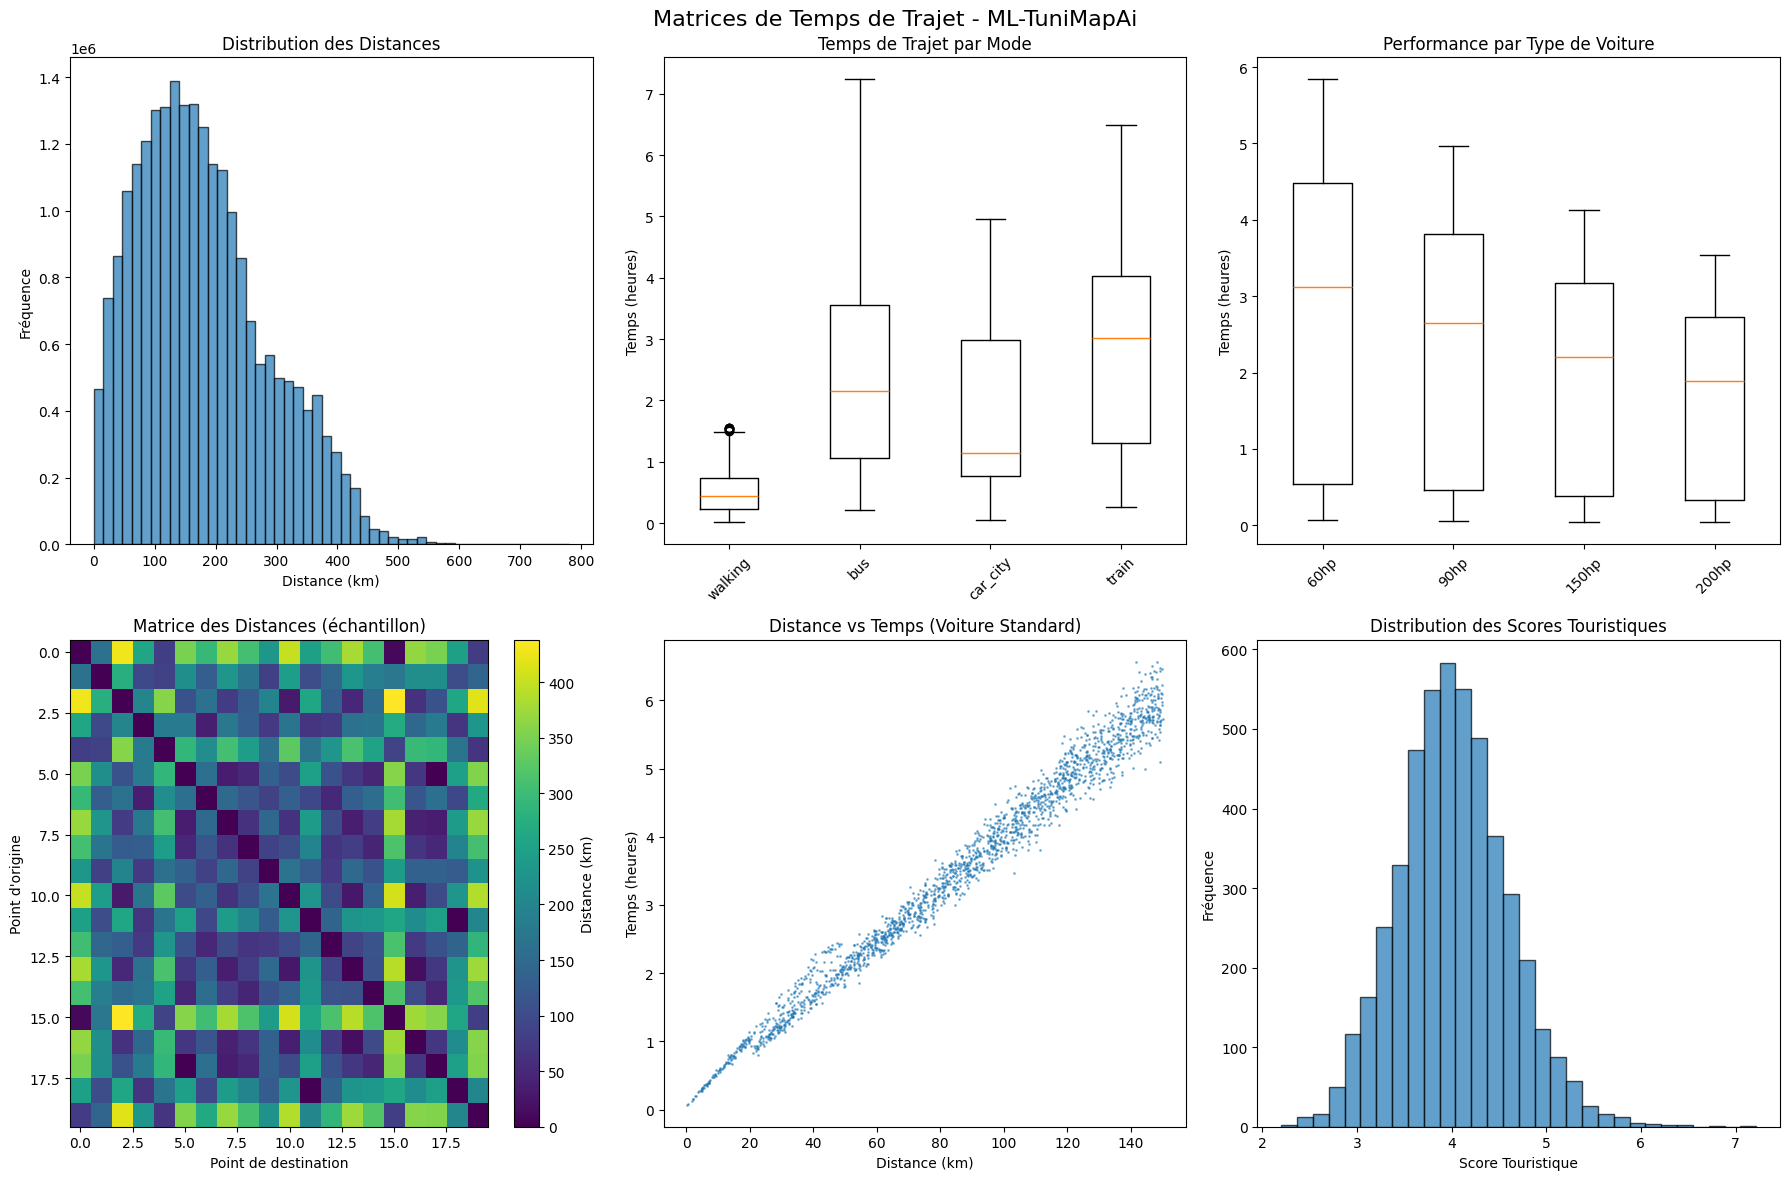

In [12]:
# 11. VISUALISATION DES RÉSULTATS
print("\n11. VISUALISATION DES RÉSULTATS")
print("-" * 60)

# Configuration des graphiques
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Matrices de Temps de Trajet - ML-TuniMapAi', fontsize=16)

# Graphique 1: Distribution des distances
finite_distances = distance_matrix[distance_matrix > 0]
axes[0,0].hist(finite_distances, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution des Distances')
axes[0,0].set_xlabel('Distance (km)')
axes[0,0].set_ylabel('Fréquence')

# Graphique 2: Comparaison des temps par mode
modes_to_compare = ['walking', 'bus', 'car_city', 'train']
times_data = []
mode_labels = []

for mode in modes_to_compare:
    if mode in travel_times:
        finite_times = travel_times[mode][np.isfinite(travel_times[mode]) & (travel_times[mode] > 0)]
        if len(finite_times) > 0:
            times_data.append(finite_times.flatten()[:1000])  # Échantillon pour la visualisation
            mode_labels.append(mode)

axes[0,1].boxplot(times_data, labels=mode_labels)
axes[0,1].set_title('Temps de Trajet par Mode')
axes[0,1].set_ylabel('Temps (heures)')
axes[0,1].tick_params(axis='x', rotation=45)

# Graphique 3: Performance des voitures
car_data = []
car_labels = []
for car_type in ['economy_60hp', 'standard_90hp', 'premium_150hp', 'sport_200hp']:
    if car_type in car_travel_times:
        finite_times = car_travel_times[car_type][np.isfinite(car_travel_times[car_type]) & (car_travel_times[car_type] > 0)]
        if len(finite_times) > 0:
            car_data.append(finite_times.flatten()[:500])
            car_labels.append(car_type.split('_')[1])

axes[0,2].boxplot(car_data, labels=car_labels)
axes[0,2].set_title('Performance par Type de Voiture')
axes[0,2].set_ylabel('Temps (heures)')
axes[0,2].tick_params(axis='x', rotation=45)

# Graphique 4: Heatmap des distances (échantillon)
sample_size = min(20, len(delegations_df))
sample_idx = np.random.choice(len(delegations_df), sample_size, replace=False)
distance_heatmap = distance_matrix[np.ix_(sample_idx, sample_idx)]

im1 = axes[1,0].imshow(distance_heatmap, cmap='viridis', aspect='auto')
axes[1,0].set_title('Matrice des Distances (échantillon)')
axes[1,0].set_xlabel('Point de destination')
axes[1,0].set_ylabel('Point d\'origine')
plt.colorbar(im1, ax=axes[1,0], label='Distance (km)')

# Graphique 5: Relation Distance vs Temps (voiture)
if 'standard_90hp' in car_travel_times:
    car_times_flat = car_travel_times['standard_90hp'].flatten()
    distances_flat = distance_matrix.flatten()
    
    # Filtrer les valeurs finies
    mask = np.isfinite(car_times_flat) & (car_times_flat > 0) & (distances_flat > 0)
    valid_distances = distances_flat[mask]
    valid_times = car_times_flat[mask]
    
    # Échantillonnage pour la performance
    sample_mask = np.random.choice(len(valid_distances), min(2000, len(valid_distances)), replace=False)
    axes[1,1].scatter(valid_distances[sample_mask], valid_times[sample_mask], alpha=0.5, s=1)
    axes[1,1].set_title('Distance vs Temps (Voiture Standard)')
    axes[1,1].set_xlabel('Distance (km)')
    axes[1,1].set_ylabel('Temps (heures)')

# Graphique 6: Distribution des scores touristiques
axes[1,2].hist(delegations_df['tourism_score'], bins=30, alpha=0.7, edgecolor='black')
axes[1,2].set_title('Distribution des Scores Touristiques')
axes[1,2].set_xlabel('Score Touristique')
axes[1,2].set_ylabel('Fréquence')

plt.tight_layout()
plt.savefig('../data/visualizations/travel_matrix_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# 12. RÉSUMÉ FINAL
print("\n12. RÉSUMÉ DE LA CONSTRUCTION DES MATRICES")
print("-" * 60)

summary = f"""
RÉSUMÉ DE LA MATRICE DE TEMPS DE TRAJET - ML-TuniMapAi:

MATRICES CALCULÉES:
✓ Distance géodésique: {distance_matrix.shape[0]}x{distance_matrix.shape[1]} points
✓ Temps de trajet: {len(travel_times)} modes de transport standard
✓ Voitures spécialisées: {len(car_travel_times)} types selon puissance
✓ Coûts et confort: Calculés pour tous les modes
✓ Réseau routier simulé: {len(road_types)} types de routes

MODES DE TRANSPORT:
{chr(10).join([f"- {mode}: Disponible" for mode in travel_times.keys()])}

TYPES DE VOITURES:
{chr(10).join([f"- {car_type}: {CAR_PERFORMANCE[car_type]['speed_factor']:.1f}x vitesse" for car_type in car_travel_times.keys()])}

STATISTIQUES CLÉS:
- Distance moyenne: {distance_matrix[distance_matrix > 0].mean():.1f} km
- Temps moyen (voiture): {car_travel_times['standard_90hp'][np.isfinite(car_travel_times['standard_90hp']) & (car_travel_times['standard_90hp'] > 0)].mean():.1f}h
- Routes touristiques: Intégration des scores d'attractivité
- Optimisation multi-critères: Temps, coût, confort

FICHIERS GÉNÉRÉS:
✓ travel_matrices.pkl (matrices principales)
✓ road_network.pkl (réseau routier)
✓ distance_matrix_sample.csv (échantillon distances)
✓ car_times_sample.csv (échantillon temps voiture)
✓ travel_matrix_analysis.png (visualisations)

FONCTIONNALITÉS DÉVELOPPÉES:
✓ Calcul de routes optimales selon préférences
✓ Génération de routes touristiques avec POI
✓ Prise en compte de la puissance des voitures
✓ Simulation du réseau routier tunisien
✓ Matrices de coût et confort

PROCHAINES ÉTAPES:
1. Entraînement des modèles ML de prédiction
2. Optimisation avancée des routes touristiques
3. Interface Streamlit interactive
4. Intégration des données météo et trafic temps réel
"""

print(summary)

# Sauvegarde du résumé
with open('../data/processed/travel_matrix_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✓ Construction des matrices terminée!")
print("✓ Résumé sauvegardé dans 'travel_matrix_summary.txt'")
print("✓ Prêt pour l'entraînement des modèles ML (notebook 04)")


12. RÉSUMÉ DE LA CONSTRUCTION DES MATRICES
------------------------------------------------------------

RÉSUMÉ DE LA MATRICE DE TEMPS DE TRAJET - ML-TuniMapAi:

MATRICES CALCULÉES:
✓ Distance géodésique: 4788x4788 points
✓ Temps de trajet: 8 modes de transport standard
✓ Voitures spécialisées: 6 types selon puissance
✓ Coûts et confort: Calculés pour tous les modes
✓ Réseau routier simulé: 4 types de routes

MODES DE TRANSPORT:
- walking: Disponible
- bike: Disponible
- bus: Disponible
- metro: Disponible
- train: Disponible
- taxi: Disponible
- car_city: Disponible
- car_highway: Disponible

TYPES DE VOITURES:
- economy_60hp: 0.8x vitesse
- standard_90hp: 1.0x vitesse
- mid_120hp: 1.1x vitesse
- premium_150hp: 1.2x vitesse
- sport_200hp: 1.4x vitesse
- luxury_300hp: 1.5x vitesse

STATISTIQUES CLÉS:
- Distance moyenne: 178.4 km
- Temps moyen (voiture): 3.5h
- Routes touristiques: Intégration des scores d'attractivité
- Optimisation multi-critères: Temps, coût, confort

FICHIERS GÉNÉR